In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('../DATA/Frozen_Dessert_Production.csv', parse_dates=True, index_col=['DATE'])

In [8]:
df

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


In [10]:
df.columns = ['Production']

In [11]:
df

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


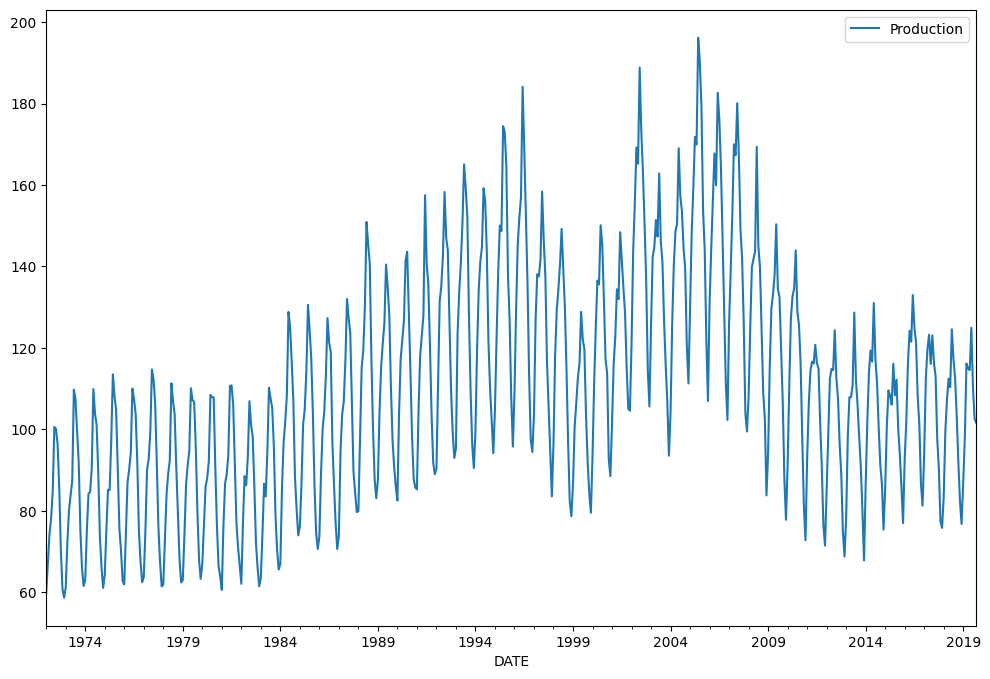

In [15]:
df.plot(figsize=(12,8))
# plt.xlim('2018-01-01', '2019-09-01')
plt.show()

In [16]:
len(df)

573

In [18]:
split = len(df) - 24

In [19]:
train = df.iloc[:split]
test = df.iloc[split:]

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
scaler = MinMaxScaler()

In [24]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [25]:
length = 18
batch_size = 1
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(data=scaled_train, targets=scaled_train, length=length, batch_size=batch_size)

In [26]:
x,y = train_generator[0]

In [27]:
x

array([[[0.00947104],
        [0.06108982],
        [0.11326273],
        [0.14145625],
        [0.18982663],
        [0.30495972],
        [0.30154406],
        [0.27416065],
        [0.19736841],
        [0.08532665],
        [0.01561588],
        [0.        ],
        [0.01774221],
        [0.09850931],
        [0.15590133],
        [0.18358944],
        [0.20878908],
        [0.37150354]]])

In [28]:
y

array([[0.3542551]])

In [30]:
val_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(data=scaled_test, targets=scaled_test, length=length, batch_size=batch_size)

In [31]:
layers = tf.keras.layers

In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [110]:
num_feat = 1
model = tf.keras.models.Sequential([
    layers.LSTM(100, activation='relu', input_shape=(length, num_feat)),
    layers.Dense(1),
])

model.compile(loss='mse', optimizer='adam')

In [111]:
model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[early_stopping])

Epoch 1/20
531/531 [==============================] - 6s 8ms/step - loss: 0.0283 - val_loss: 0.0044
Epoch 2/20
531/531 [==============================] - 4s 8ms/step - loss: 0.0089 - val_loss: 0.0018
Epoch 3/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 4/20
531/531 [==============================] - 4s 8ms/step - loss: 0.0038 - val_loss: 0.0066
Epoch 5/20
531/531 [==============================] - 5s 8ms/step - loss: 0.0037 - val_loss: 0.0022


In [112]:
losses = pd.DataFrame(model.history.history)

<Axes: >

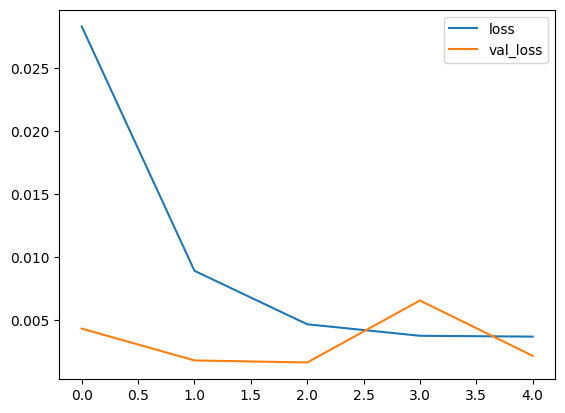

In [113]:
losses.plot()

In [114]:
eval_batch = scaled_train[-length:].reshape(1,length,num_feat)

In [115]:
model.predict(eval_batch)

1/1 [==============================] - 0s 214ms/step


array([[0.23339333]], dtype=float32)

In [116]:
scaled_test[0]

array([0.23134679])

In [117]:
test_predictions = []
eval_batch = scaled_train[-length:].reshape(1,length,num_feat)

for _ in range(len(scaled_test)):
    pred = model.predict(eval_batch)
    test_predictions.append(pred[0])
    eval_batch = np.append(eval_batch[:,1:,:], [pred], axis=1)

1/1 [==============================] - 0s 26ms/step


In [118]:
test_predictions

[array([0.23339333], dtype=float32),
 array([0.1963132], dtype=float32),
 array([0.2273964], dtype=float32),
 array([0.31307784], dtype=float32),
 array([0.3844915], dtype=float32),
 array([0.44154635], dtype=float32),
 array([0.48058236], dtype=float32),
 array([0.49414212], dtype=float32),
 array([0.472272], dtype=float32),
 array([0.41472512], dtype=float32),
 array([0.33835715], dtype=float32),
 array([0.2608652], dtype=float32),
 array([0.20406832], dtype=float32),
 array([0.20728122], dtype=float32),
 array([0.27858275], dtype=float32),
 array([0.3610537], dtype=float32),
 array([0.42723694], dtype=float32),
 array([0.4836364], dtype=float32),
 array([0.5127149], dtype=float32),
 array([0.5083574], dtype=float32),
 array([0.4624238], dtype=float32),
 array([0.38820225], dtype=float32),
 array([0.3012786], dtype=float32),
 array([0.22641246], dtype=float32)]

In [119]:
true_test_predictions = scaler.inverse_transform(test_predictions)

In [120]:
test['Predictions'] = true_test_predictions

C:\Users\Nagant\AppData\Local\Temp\ipykernel_9128\2371203732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_test_predictions


<Axes: xlabel='DATE'>

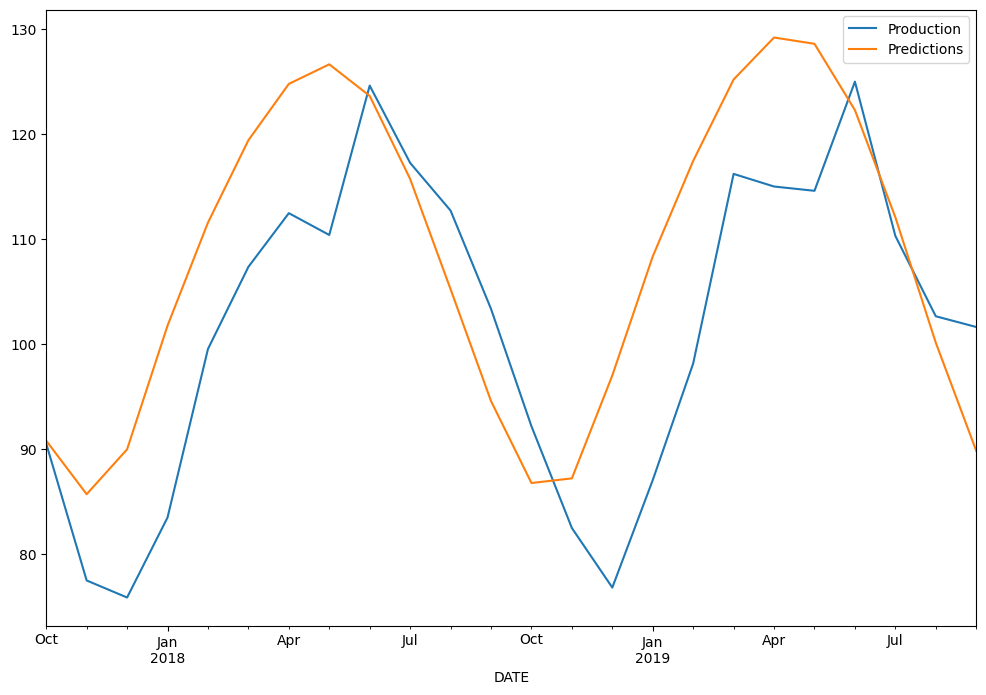

In [121]:
test.plot(figsize=(12,8))

In [122]:
full_scaled_data = scaler.fit_transform(df)

In [123]:
full_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(data=full_scaled_data, targets=full_scaled_data, length=length, batch_size=batch_size)

In [124]:
full_model = tf.keras.models.Sequential([
    layers.LSTM(100, activation='relu', input_shape=(length, num_feat)),
    layers.Dense(1),
])

full_model.compile(loss='mse', optimizer='adam')

In [125]:
full_model.fit(full_gen, epochs=4)

Epoch 1/4
555/555 [==============================] - 6s 8ms/step - loss: 0.0261
Epoch 2/4
555/555 [==============================] - 6s 10ms/step - loss: 0.0117
Epoch 3/4
555/555 [==============================] - 6s 11ms/step - loss: 0.0045
Epoch 4/4
555/555 [==============================] - 5s 8ms/step - loss: 0.0035


In [126]:
forecast = []
eval_batch = full_scaled_data[-length:].reshape(1,length,num_feat)

for _ in range(18):
    pred = model.predict(eval_batch)
    forecast.append(pred[0])
    eval_batch = np.append(eval_batch[:,1:,:], [pred], axis=1)

1/1 [==============================] - 0s 30ms/step


In [127]:
true_forecast = scaler.inverse_transform(forecast)

In [128]:
true_forecast

array([[ 88.66393932],
       [ 82.51966263],
       [ 85.65222123],
       [ 96.82965744],
       [106.75466117],
       [114.78108032],
       [120.81180726],
       [122.95154419],
       [120.13478317],
       [112.69431306],
       [102.94423833],
       [ 93.04329534],
       [ 85.13182344],
       [ 84.05547157],
       [ 92.46152034],
       [104.11473893],
       [113.1368813 ],
       [120.90026763]])

In [129]:
df

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


In [130]:
forecast_index = pd.date_range(start='2019-09-01', freq='MS', periods=18)

In [131]:
forecast_index

DatetimeIndex(['2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01'],
              dtype='datetime64[ns]', freq='MS')

In [132]:
forecast_df = pd.DataFrame(data=true_forecast, index=forecast_index, columns=['Forecast'])

<Axes: xlabel='DATE'>

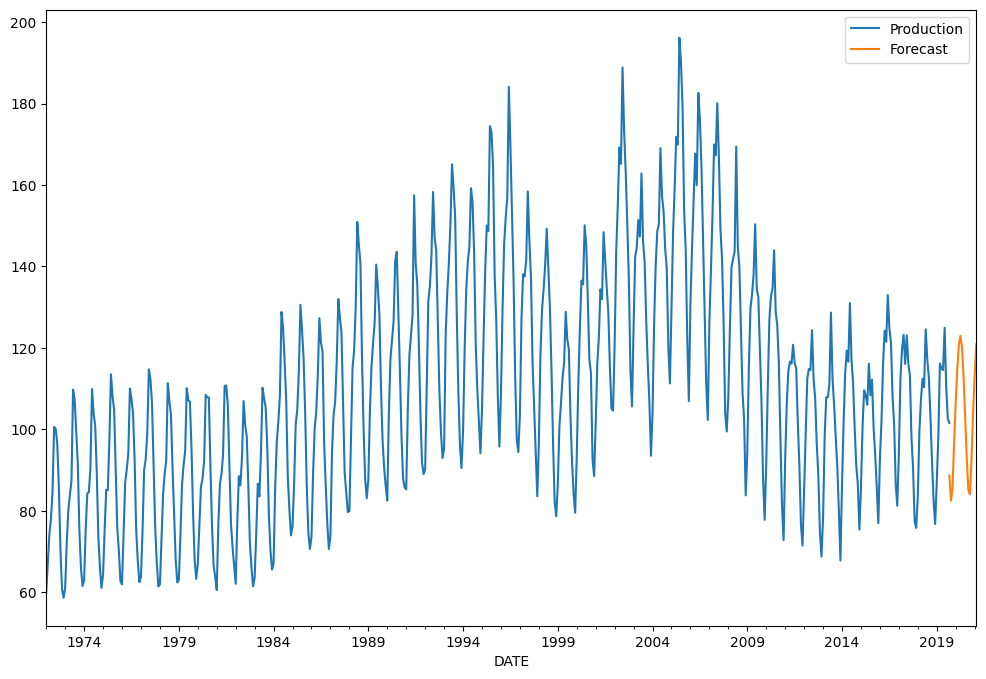

In [133]:
ax=df.plot(figsize=(12,8))
forecast_df.plot(ax=ax)

(576.0, 616.0)

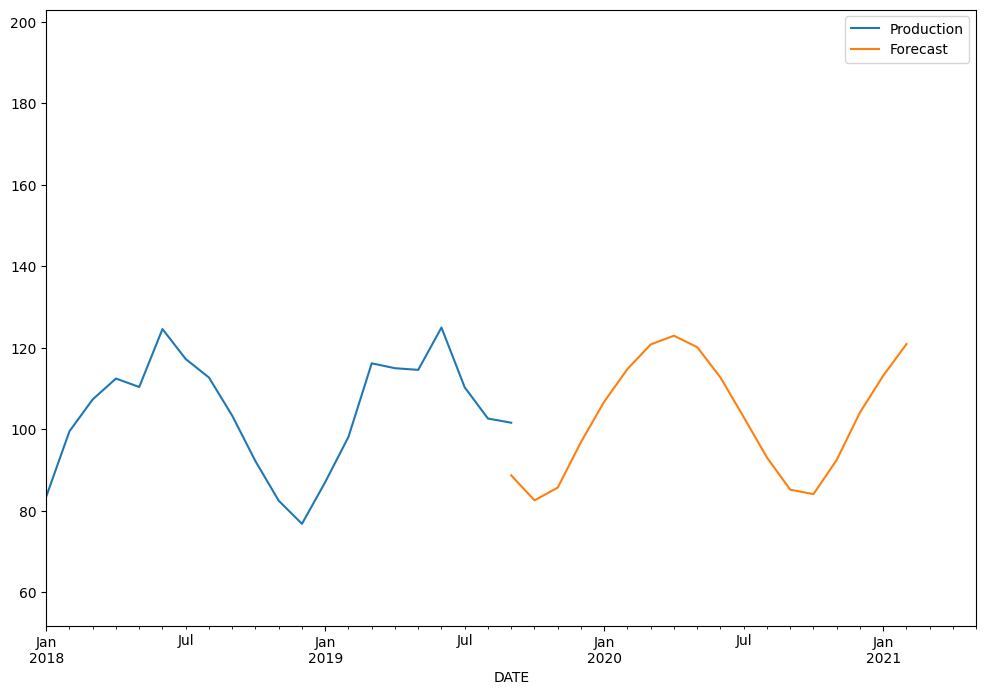

In [135]:
ax=df.plot(figsize=(12,8))
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01', '2021-05-01')

In [136]:
from sklearn.metrics import mean_squared_error

In [137]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,90.754627
2017-11-01,77.4378,85.655594
2017-12-01,75.8118,89.929966
2018-01-01,83.4343,101.712354
2018-02-01,99.4899,111.532726
2018-03-01,107.3152,119.378561
2018-04-01,112.4309,124.746554
2018-05-01,110.3544,126.611209
2018-06-01,124.5841,123.603766


In [139]:
np.sqrt(mean_squared_error(test['Production'], test['Predictions']))

11.84107133170829